This notebook pre-processes the data and fine-tunes a pre-trained BERT model for the task of text classification. We follow instructions from the Hugging Face website to fine tune the transformer model which can be found [here](https://huggingface.co/docs/transformers/training). 

The model we chose was roberta-small, from KLUE (Korean Language Understanding Evaluation) available [here](https://huggingface.co/klue/roberta-small)

The dataset we use is the [KoPolitic](https://github.com/Kdavid2355/KoPolitic-Benchmark-Dataset/tree/main) dataset which is comprised of 12,000 korean news articles collected from across six leading newspapers in South Korea. Each example includes two different classifications. First, the political orientation of the article: either conservative, moderate conservative, moderate, moderate liberal, or liberal. Second, the level of pro-government sentiment in the article: either pro-government advocacy, moderate advocacy, moderate, moderate criticism, anti-government criticism or none. 

The goal of this notebook is to fine-tune the pre-trained model to predict the political orientation of the article.

# Imports

In [35]:
# Here we could do import "as pd" to rename the pandas library
import pandas
# Here we use the alias because this library is long
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# Torch is machine learning library
import torch

# Transformers is a library for NLP (Natural Language Processing) made by Hugging Face
# AutoTokenizer is a class used to import a tokenizer for a specific model
# AutoModelForSequenceClassification is a class used to import a model for a specific task
# TrainingArguments is a class used to define the training arguments
# Trainer is a class used to train a model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Datasets is a library for datasets made by Hugging Face
from datasets import Dataset

# Evaluate is a library to evaluate the model
import evaluate
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In Machine Learning, we usually have 3 steps: 
- Data Preprocessing: consists of cleaning, analyzing, and preparing data for training the ML models.
- Training: consists of training the ML models on the preprocessed data.
- Evaluation: consists of testing the trained ML models on new data to evaluate their performance.

In this notebook, we will perfom all these steps to analyze and predict the political orientation of the articles.

# Dataset Analysis and Preprocessing

## Importing the dataset

We will start by importing the dataset in our code.

In [2]:
# Import the csv file using pandas
# We use the read_csv method from the pandas library
# This function takes as input the file path of the csv file
train_dataset = pandas.read_csv("political_orientation_dataset/kopolitic_train.csv")
test_dataset = pandas.read_csv("political_orientation_dataset/kopolitic_test.csv")

# Here we print the first 5 rows of the dataset
print(train_dataset.head())

   seq                                     title        date  \
0    0     최경환·우병우…TK 연고 '올드보이' 총선 앞두고 정치 재개 움직임  2023-08-03   
1    1           미군 '월북' 2주 넘었는데… 북한은 여전히 '침묵' 중  2023-08-03   
2    2     [속보] 한 총리 "새만금 잼버리 참가자 4만명 안전 확보" 지시   2023-08-03   
3    3         김영호 "납북자·억류자 문제에 확고한 입장으로 대응할 것"   2023-08-03   
4    4  "충북도 국장, 배우자 일하는 증평군 지표 고쳐 136억원 부당 지원"   2023-08-03   

                                             content  \
0  \n\n\n\n\n\n\n최경환 전 경제부총리 등 TK(대구·경북)에 연고가 있는 ...   
1  \n\n\n\n\n\n\n지난달 18일 판문점 공동경비구역을 통해 무단 월북한 트래...   
2  \n\n\n\n\n\n\n윤석열 대통령과 김건희 여사가 지난 2일 전북 부안군 새만...   
3  \n\n\n\n\n\n\n김영호 통일부 장관이 3일 서울 종로구 정부서울청사에서 납...   
4  \n\n\n\n\n\n\n감사원 전경 2014.9.2/뉴스1 © News1 이종덕 ...   

                              article_url  label1  label2  
0  https://www.news1.kr/articles/?5129788       3       0  
1  https://www.news1.kr/articles/?5129591       3       0  
2  https://www.news1.kr/articles/?5129823       3       3  
3  https://www.news1.kr/articles/?5129

We notice that the dataset has 7 columns:
- `seq`: the sequence number of the article (we will not use this column and thus delete it)
- `title`: the title of the article
- `date`: the date of the article
- `content`: the content of the article
- `article_url`: the url of the article (we will not use this column and thus delete it)
- `label1`: the political orientation of the article (our target variable)
- `label2`: the level of pro-government sentiment in the article (we will not use this column but we will not delete it to conduct some analysis on it first)

In [3]:
# First we show which columns has NaNs values
print(train_dataset.isnull().sum())
print(test_dataset.isnull().sum())

seq            0
title          0
date           0
content        0
article_url    0
label1         0
label2         0
dtype: int64
seq            0
title          0
date           0
content        0
article_url    0
label1         0
label2         0
dtype: int64


In [4]:
# Drop the "seq" and "article_url" columns because they are not useful for the model for both train and test datasets
train_dataset = train_dataset.drop(columns=["seq", "article_url"])
test_dataset = test_dataset.drop(columns=["seq", "article_url"])

print(train_dataset.head())

                                      title        date  \
0     최경환·우병우…TK 연고 '올드보이' 총선 앞두고 정치 재개 움직임  2023-08-03   
1           미군 '월북' 2주 넘었는데… 북한은 여전히 '침묵' 중  2023-08-03   
2     [속보] 한 총리 "새만금 잼버리 참가자 4만명 안전 확보" 지시   2023-08-03   
3         김영호 "납북자·억류자 문제에 확고한 입장으로 대응할 것"   2023-08-03   
4  "충북도 국장, 배우자 일하는 증평군 지표 고쳐 136억원 부당 지원"   2023-08-03   

                                             content  label1  label2  
0  \n\n\n\n\n\n\n최경환 전 경제부총리 등 TK(대구·경북)에 연고가 있는 ...       3       0  
1  \n\n\n\n\n\n\n지난달 18일 판문점 공동경비구역을 통해 무단 월북한 트래...       3       0  
2  \n\n\n\n\n\n\n윤석열 대통령과 김건희 여사가 지난 2일 전북 부안군 새만...       3       3  
3  \n\n\n\n\n\n\n김영호 통일부 장관이 3일 서울 종로구 정부서울청사에서 납...       2       4  
4  \n\n\n\n\n\n\n감사원 전경 2014.9.2/뉴스1 © News1 이종덕 ...       3       0  


We notice that not a single row has missing values in both training and testing. We will thus not need to handle missing values in this dataset.

## Data Analysis

We will now proceed to perform some data analysis on the dataset. We aim to plot the distribution of the `date`, `label1`, and `label2` columns. We also want to get an idea of the average length of the articles in the dataset.

In [5]:
# We define a function named plot_distribution
# This function will plot the distribution of a given column in the dataset
def plot_distribution(dataset_column, column_name, title, colors):
    # inputs: dataset_column, column_name, title
    # We first compute the percentage of each source, we use the value_counts method from the pandas library to count the number of occurences of each source
    counts = dataset_column.value_counts() # this returns a pandas series with the number of occurences of each variable given in the column
    print(counts)

    percentage = counts/counts.sum() * 100 # we compute the percentage of each source

    # We use matplotlib to plot the distribution
    plt.bar(percentage.index, percentage, color=colors, width=0.5, linewidth=1, edgecolor='black')

    # We are going to label the exact count of each source on the bars
    for i in range(len(percentage)):
        # bar_title = str(round(percentage[i], 2)) + "% (" + str(counts[i]) + ")"
        bar_title = f"{round(percentage[i], 2)}% ({counts[i]})" # Equivalent to above, but using f-string
        plt.text(i, percentage[i],  bar_title, ha='center', va='bottom')

    plt.ylabel('Percentage')
    plt.xlabel(column_name)
    plt.title(title)
    plt.show()

### Distribution of the `date` column

We need to isolate the year for each example.

In [6]:
print("Original Date column:")
print(train_dataset['date'])

Original Date column:
0        2023-08-03
1        2023-08-03
2        2023-08-03
3        2023-08-03
4        2023-08-03
           ...     
4495    2023.05.18.
4496    2023.05.18.
4497    2023.05.18.
4498    2023.05.17.
4499    2023.05.17.
Name: date, Length: 4500, dtype: object


We notice that some datse are in the format `YYYY-MM-DD` and some are in the format `YYYY.MM.DD`. We will need to handle this.

In [7]:
year = train_dataset['date'].str.split('-').str[0]
year = year.str.split('.').str[0]

# CHeck that the obtained year column is not a single value
print(year.value_counts())

date
2023    4500
Name: count, dtype: int64


We conclude that all articles were written in the year 2023. We can try to analyze the distribution of the articles over the months.

date
07    2253
06     453
08     289
04     254
05     187
Name: count, dtype: int64


/var/folders/dk/m9d4fkln0d947z3d_fc1m8000000gn/T/ipykernel_19106/3600228608.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bar_title = f"{round(percentage[i], 2)}% ({counts[i]})" # Equivalent to above, but using f-string
/var/folders/dk/m9d4fkln0d947z3d_fc1m8000000gn/T/ipykernel_19106/3600228608.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, percentage[i],  bar_title, ha='center', va='bottom')


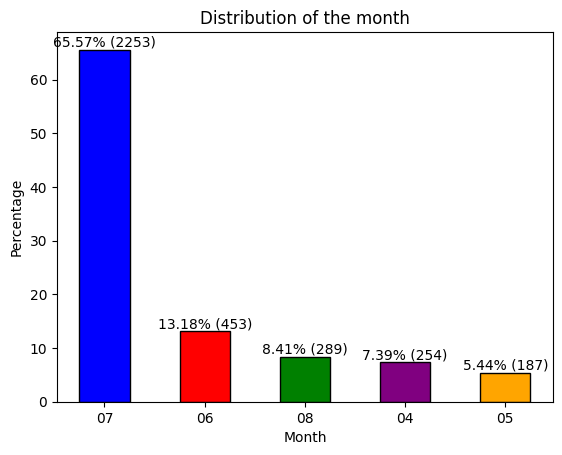

In [8]:
month = train_dataset['date'].str.split('-').str[1]
month = month.str.split('.').str[0]

# CHeck that the obtained month column is not a single value
plot_distribution(month, "Month", "Distribution of the month", ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink', 'grey', 'cyan', 'magenta', 'black'])

We analyze that most comments were written in the month of July 2023 with 65.57% of the articles.

### Distribution of the `label1` column

In [9]:
print("Original target column (political orientation):")
print(train_dataset['label1'])

Original target column (political orientation):
0       3
1       3
2       3
3       2
4       3
       ..
4495    3
4496    3
4497    3
4498    4
4499    4
Name: label1, Length: 4500, dtype: int64


label1
2    1931
3    1253
1     748
0     358
4     210
Name: count, dtype: int64


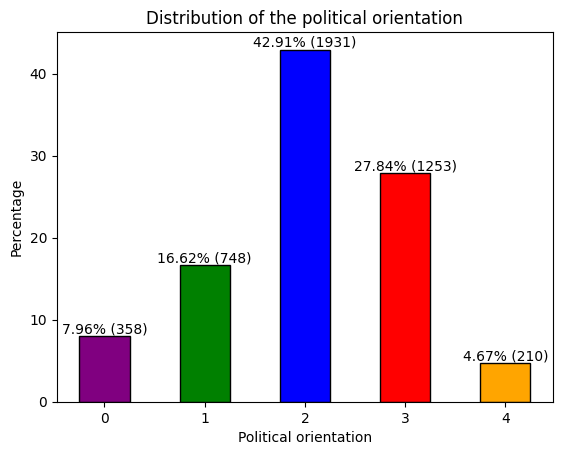

In [10]:
plot_distribution(train_dataset['label1']-1, "Political orientation", "Distribution of the political orientation", ['blue', 'red', 'green', 'purple', 'orange'])

ON this graph, the label `0` corresponds to `liberal`, `1` corresponds to `moderate liberal`, `2` corresponds to `moderate`, `3` corresponds to `moderate conservative`, and `4` corresponds to `conservative`. We notice that most examples are `moderate` with 42.91% of the examples, followed by `moderate conservative` with 27.84% of the examples.

### Distribution of the `label2` column

In [11]:
print("Original target column (level of pro-government):")
print(train_dataset['label2'])

Original target column (level of pro-government):
0       0
1       0
2       3
3       4
4       0
       ..
4495    4
4496    0
4497    4
4498    4
4499    4
Name: label2, Length: 4500, dtype: int64


label2
0    1832
3     890
4     681
2     478
1     408
5     211
Name: count, dtype: int64


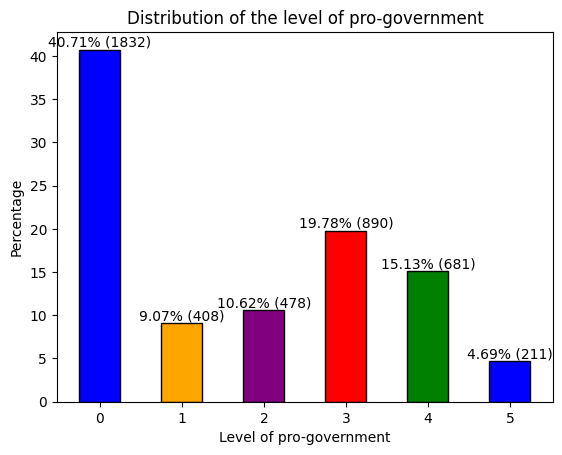

In [12]:
plot_distribution(train_dataset['label2'], "Level of pro-government", "Distribution of the level of pro-government", ['blue', 'red', 'green', 'purple', 'orange'])

On this graph, the label `0` corresponds to `none`, `1` corresponds to `criticism`, `2` corresponds to `moderate criticism`, `3` corresponds to `moderate`, `4` corresponds to `moderate advocacy`, and `5` corresponds to `advocacy`. We notice that most examples are `none` with 40.71% of the examples, followed by `moderate` with 19.78% of the examples.

### Correlation between the `label1` and `label2` columns

We now aim to explore if there is a correlation between the 2 labels: are liberal articles more likely to be pro-government advocacy or anti-government criticism? Same question for conservative articles. We will show a bar plot with one bar for each possible label in `label2` divided in parts for each possible label in `label1`.

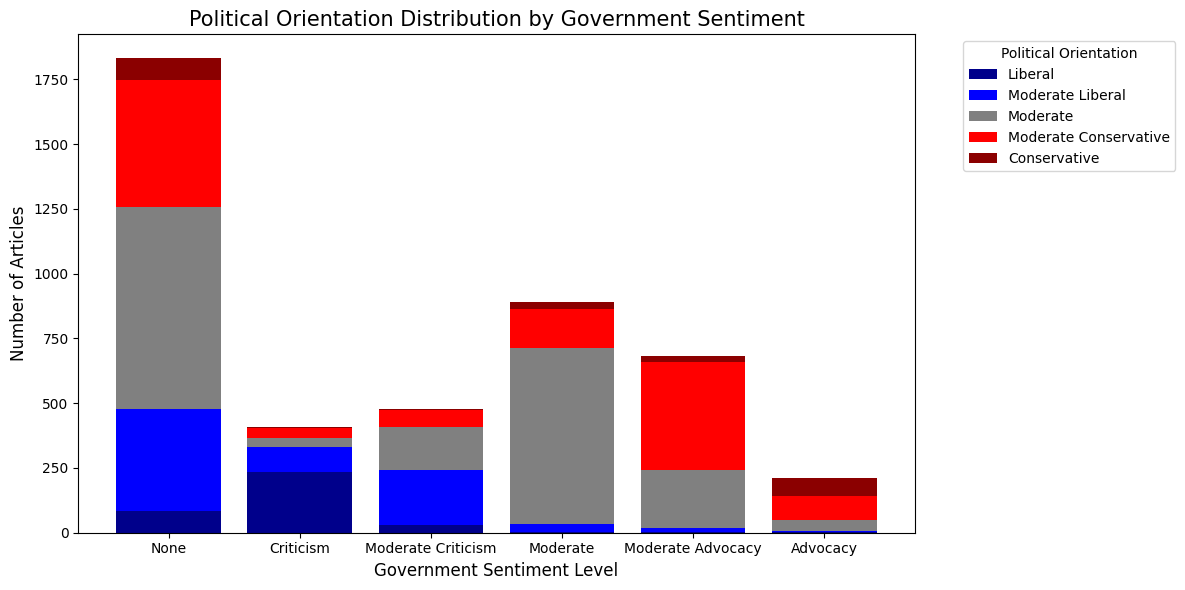

In [13]:
# Group data by government sentiment and political orientation
grouped = train_dataset.groupby(['label2', 'label1']).size().unstack(fill_value=0)

# Define political orientation labels and colors
orientation_labels = ['Liberal', 'Moderate Liberal', 'Moderate', 
                        'Moderate Conservative', 'Conservative']

x_labels = ['None', 'Criticism', 'Moderate Criticism', 'Moderate', 'Moderate Advocacy', 'Advocacy']

colors = ['darkblue', 'blue', 'gray', 'red', 'darkred']

# Create the plot
plt.figure(figsize=(12, 6))

# Create stacked bar plot
bottom = np.zeros(len(grouped))
for i, (orientation, color) in enumerate(zip(orientation_labels, colors)):
    values = grouped[i+1]  # Adjust index since your labels start at 1
    plt.bar(grouped.index, values, bottom=bottom, label=orientation, color=color)
    bottom += values

# Customize the plot
plt.title('Political Orientation Distribution by Government Sentiment', fontsize=15)
plt.xlabel('Government Sentiment Level', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.xticks(grouped.index, x_labels)
plt.legend(title='Political Orientation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


We see that articles qualified as `None` have a high proprtion of `Moderate`, `Moderate Conservative`, and `Moderate Liberal` articles. Conservative and TODO

## Data Preprocessing

This section formats the dataset in a way that is suitable for training the ML models. The first thing we do is define the columns we will keep as input to the ML model and the columns we will use for prediction. In our case, we will just keep the `title` and `content` columns as input and only the `label1` column as the target (we only predict the political orientation, we ignore the pro-government level).

In [14]:
# Only keep the columns we need
train_dataset = train_dataset.drop(columns=['date', 'label2'])
test_dataset = test_dataset.drop(columns=['date', 'label2'])

print(train_dataset.head())

                                      title  \
0     최경환·우병우…TK 연고 '올드보이' 총선 앞두고 정치 재개 움직임   
1           미군 '월북' 2주 넘었는데… 북한은 여전히 '침묵' 중   
2     [속보] 한 총리 "새만금 잼버리 참가자 4만명 안전 확보" 지시    
3         김영호 "납북자·억류자 문제에 확고한 입장으로 대응할 것"    
4  "충북도 국장, 배우자 일하는 증평군 지표 고쳐 136억원 부당 지원"    

                                             content  label1  
0  \n\n\n\n\n\n\n최경환 전 경제부총리 등 TK(대구·경북)에 연고가 있는 ...       3  
1  \n\n\n\n\n\n\n지난달 18일 판문점 공동경비구역을 통해 무단 월북한 트래...       3  
2  \n\n\n\n\n\n\n윤석열 대통령과 김건희 여사가 지난 2일 전북 부안군 새만...       3  
3  \n\n\n\n\n\n\n김영호 통일부 장관이 3일 서울 종로구 정부서울청사에서 납...       2  
4  \n\n\n\n\n\n\n감사원 전경 2014.9.2/뉴스1 © News1 이종덕 ...       3  


In [15]:
# Now we combine the title and content column by just appending the content to the title
train_dataset['text'] = train_dataset['title'] + " " + train_dataset['content']
test_dataset['text'] = test_dataset['title'] + " " + test_dataset['content']

# Drop the context and comment columns
train_dataset = train_dataset.drop(columns=['title', 'content'])
test_dataset = test_dataset.drop(columns=['title', 'content'])

print(train_dataset.head())

   label1                                               text
0       3  최경환·우병우…TK 연고 '올드보이' 총선 앞두고 정치 재개 움직임 \n\n\n\n...
1       3  미군 '월북' 2주 넘었는데… 북한은 여전히 '침묵' 중 \n\n\n\n\n\n\n...
2       3  [속보] 한 총리 "새만금 잼버리 참가자 4만명 안전 확보" 지시  \n\n\n\n...
3       2  김영호 "납북자·억류자 문제에 확고한 입장으로 대응할 것"  \n\n\n\n\n\n...
4       3  "충북도 국장, 배우자 일하는 증평군 지표 고쳐 136억원 부당 지원"  \n\n\...


In [16]:
# Rename the label1 column to label
train_dataset = train_dataset.rename(columns={"label1": "label"})
test_dataset = test_dataset.rename(columns={"label1": "label"})

print(train_dataset.head())

   label                                               text
0      3  최경환·우병우…TK 연고 '올드보이' 총선 앞두고 정치 재개 움직임 \n\n\n\n...
1      3  미군 '월북' 2주 넘었는데… 북한은 여전히 '침묵' 중 \n\n\n\n\n\n\n...
2      3  [속보] 한 총리 "새만금 잼버리 참가자 4만명 안전 확보" 지시  \n\n\n\n...
3      2  김영호 "납북자·억류자 문제에 확고한 입장으로 대응할 것"  \n\n\n\n\n\n...
4      3  "충북도 국장, 배우자 일하는 증평군 지표 고쳐 136억원 부당 지원"  \n\n\...


## Train-Test Split

Now in order to train our model and properly evaluate it, we need to split our dataset in three different sets:
- Training set: used to train the model.
- Validation set: Usually, when training a model, there is a lot of uncertainty which are linked to parameters that we give to the model when we start the training. For that reason, we somtimes like to try different parameters, thus resulting in multiple models being trained. This validation set is just used to compare these models and choose the best one.
- Test set: This set is used to evaluate the final and best model on unseen data.

For the sake of this experiment, we will not use a validation set because we will not train multiple models with different parameters. We will just train one model and evaluate it on the test set. Note that the split of train and test was already done by the creators of the dataset.

# Model Training

In [17]:
# The model we use is from the Hugging Face library
# https://huggingface.co/klue/roberta-small
model_name = 'klue/roberta-base'

# Device is for PyTorch 
# It determines where the model will be run (CPU aka Processor or GPU aka Graphics Card)
# In our case, we have an Apple silicon Mac, so we use the 'mps' device
device = torch.device('mps')

# We load the tokenizer and model from the Hugging Face library
tokenizer = AutoTokenizer.from_pretrained(model_name)

# We load the model from the Hugging Face library
# We load the model on the device we defined above
num_labels = len(train_dataset['label'].unique())
print(num_labels)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(train_dataset['label'].unique())).to(device)

5


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# We need to conver our korean dataset to a format that the model can understand
# We use the Dataset class from the Hugging Face library
# We have to reset the index of the training and testing datasets, which means we forget about row numbers
# If we don't each row will have a row number associated with it
train_dataset = Dataset.from_pandas(train_dataset.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_dataset.reset_index(drop=True))

# Print the first example in the training dataset
print(train_dataset[0])

{'label': 3, 'text': '최경환·우병우…TK 연고 \'올드보이\' 총선 앞두고 정치 재개 움직임 \n\n\n\n\n\n\n최경환 전 경제부총리 등 TK(대구·경북)에 연고가 있는 인사들이 내년 총선을 앞두고 재기를 위한 \'정중동\' 행보에 나서는 분위기가 감지되고 있다. 사진은 최 전 경제부총리(완쪽)가 지난 5월 서울 여의도 페어몬트 호텔에서 열린 경제개발 5개년 계획 수립 60주년 기념 국제컨퍼런스에 참석해 추경호 경제부총리와 인사하는 모습. 2023.5.25/뉴스1 © News1 신웅수 기자\n\n\n\nTK(대구·경북)에 연고를 둔 \'올드보이\'들이 내년 총선을 앞두고 정치 재기에 나서는 모습이다.\'친박(親박근혜)계 좌장\'으로 꼽히는 등 박근혜 정부의 실세였던 최경환 전 경제부총리와 우병우 전 청와대 민정수석 등이 국민의힘 간판을 내걸고 내년 총선에 출마할 것이라는 설이 파다하다.3일 정치권에 따르면 최 전 부총리는 주소지를 둔 서울 서초동과 고향인 경북 경산을 오가며 정계 인사 등과 회동하는 등 정치적 접촉면을 넓히는 것으로 알려졌다.4선을 지낸 지역구(경산시)에서 출마를 준비하는 것으로 전해진 그에 대해 "공천을 못받으면 무소속으로 나올 것"이라는 말도 나오고 있다.특히 지난 6월30일 \'비윤\'(非윤석열)계로 꼽히는 이준석 전 국민의힘 대표와 김용태 전 청년최고위원, 이기인 경기도의원 등과 만난 것이 확인되면서 내년 총선을 앞두고 \'보수 대통합\'에 나선 것 아니냐는 시각도 있다.최 전 부총리는 이 전 대표 등과 만나 보수 대연합의 당위성을 강조하면서 "여당의 내년 총선 승리를 위해서는 \'반윤 연합\'이 아니라 \'보수 통합\'이 절실하다"고 조언한 것으로 전해졌다.정가에서는 \'최 전 부총리가 추석을 전후해 입장을 밝히지 않겠느냐\'고 전망하고 있다.경제관료 출신인 최 전 부총리는 17대 국회 경북 경산·청도 지역구에서 당선된 후 내리 4선을 지냈다.최 전 부총리는 2019년 국정원 특별활동비 상납 사건으로 구속된 뒤 

In [19]:
# We define a function to tokenize the text in the dataset
# We use the tokenizer we loaded above
# We use the padding and truncation options to ensure all examples have the same length
# This is because the model requires all examples to have the same length, if one example is shorter than the maximum length, it will be padded with zeros at the end
# If one example is longer than the maximum length, it will be truncated
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# We apply the function to the training and testing datasets
# This will print a progress bar
train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)

# Print the first example in the training dataset
print(train_dataset_tokenized[0])

Map: 100%|██████████| 500/500 [00:00<00:00, 2916.61 examples/s]

{'label': 3, 'text': '최경환·우병우…TK 연고 \'올드보이\' 총선 앞두고 정치 재개 움직임 \n\n\n\n\n\n\n최경환 전 경제부총리 등 TK(대구·경북)에 연고가 있는 인사들이 내년 총선을 앞두고 재기를 위한 \'정중동\' 행보에 나서는 분위기가 감지되고 있다. 사진은 최 전 경제부총리(완쪽)가 지난 5월 서울 여의도 페어몬트 호텔에서 열린 경제개발 5개년 계획 수립 60주년 기념 국제컨퍼런스에 참석해 추경호 경제부총리와 인사하는 모습. 2023.5.25/뉴스1 © News1 신웅수 기자\n\n\n\nTK(대구·경북)에 연고를 둔 \'올드보이\'들이 내년 총선을 앞두고 정치 재기에 나서는 모습이다.\'친박(親박근혜)계 좌장\'으로 꼽히는 등 박근혜 정부의 실세였던 최경환 전 경제부총리와 우병우 전 청와대 민정수석 등이 국민의힘 간판을 내걸고 내년 총선에 출마할 것이라는 설이 파다하다.3일 정치권에 따르면 최 전 부총리는 주소지를 둔 서울 서초동과 고향인 경북 경산을 오가며 정계 인사 등과 회동하는 등 정치적 접촉면을 넓히는 것으로 알려졌다.4선을 지낸 지역구(경산시)에서 출마를 준비하는 것으로 전해진 그에 대해 "공천을 못받으면 무소속으로 나올 것"이라는 말도 나오고 있다.특히 지난 6월30일 \'비윤\'(非윤석열)계로 꼽히는 이준석 전 국민의힘 대표와 김용태 전 청년최고위원, 이기인 경기도의원 등과 만난 것이 확인되면서 내년 총선을 앞두고 \'보수 대통합\'에 나선 것 아니냐는 시각도 있다.최 전 부총리는 이 전 대표 등과 만나 보수 대연합의 당위성을 강조하면서 "여당의 내년 총선 승리를 위해서는 \'반윤 연합\'이 아니라 \'보수 통합\'이 절실하다"고 조언한 것으로 전해졌다.정가에서는 \'최 전 부총리가 추석을 전후해 입장을 밝히지 않겠느냐\'고 전망하고 있다.경제관료 출신인 최 전 부총리는 17대 국회 경북 경산·청도 지역구에서 당선된 후 내리 4선을 지냈다.최 전 부총리는 2019년 국정원 특별활동비 상납 사건으로 구속된 뒤 

We notice that after tokenizing, our input data now has one extra information: `input_ids`. This is the tokenized version of the input data. Each characater in the input data is now represented by a number. This is the format that the model can understand, and this is also why we needed to tokenize the input data.

Note that it starts with a 0: this is the token for the start of the sentence and is not a character in the input data.
The input is also padded with 1s at the end to make sure that all inputs have the same length. This is necessary because the model can only work with inputs of the same length.

Not a single character will be 0 nor 1 in the input data, so the model will know that 0 or 1 is a padding token and not a character in the input data.

In [20]:
# We create the Training Arguments object
# This object contains all the arguments / paramaters needed to train the model
# Training can take a long time, and so we want to save checkpoints of the model during training
# We also want to save one checkpoint at the end, so that we don't have to retrain the model, we can just reload it and use it for future applications
# An epoch is one iteration over the entire dataset
training_args = TrainingArguments(output_dir="./political_orientation_models", # The output directory where the model checkpoints will be saved during training.
                                eval_strategy="epoch",  # The evaluation strategy to use during training: at each epoch we evaluate the model
                                save_strategy="epoch",  # The checkpoint save strategy to use during training: at each epoch we save the model
                                per_device_train_batch_size=16, # The batch size to use during training, here we pass 8 examples per batch
                                per_device_eval_batch_size=16,  # The batch size to use during evaluation, here we pass 8 examples per batch
                                num_train_epochs=3,   # The number of epochs to train the model, here we pass 3 epochs on the dataset
                                logging_dir="./logs", # The directory where logs are saved
                                logging_steps=100, # The number of steps before logging the training loss
                                load_best_model_at_end=True, 
                                metric_for_best_model="accuracy") # Load the best model at the end of training based on the accuracy metric

# Trainer does not automatically evaluate the model during training on the test set
# We have to do this manually
# We create the metrics function to evaluate the model on the test set
# Metric here is a function that takes the predictions and true labels of our dataset as input and returns the accuracy
# We decided to take the accuracy as the metric to evaluate the model because it is a classification task
metric = evaluate.load("accuracy")

In [21]:
# Call compute on metric to calculate the accuracy of your predictions.
# Before passing your predictions to compute, you need to convert the logits to predictions (remember all Hugging Face Transformers models return logits):
def compute_metrics(eval_pred):
    # Logits are just probabilities!
    # SO the model is not directly predicting if a comment is offensive or not, it is predicting the probability of a comment being offensive
    # More preciesly, logits is a list of probabilities for each class possible (in our case 26)
    logits, labels = eval_pred
    
    # We need to convert logits to a prediction among the 26 classes
    # To do so, we take the class with the highest probability (we use np.argmax to find the index of the highest probability for efficiency)
    predictions = np.argmax(logits, axis=-1)

    # We return the accuracy of the model using the imported metric
    return metric.compute(predictions=predictions, references=labels)

In [22]:
# Finally, we create the Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

 12%|█▏        | 100/846 [02:18<17:13,  1.39s/it]

{'loss': 1.1563, 'grad_norm': 4.394130706787109, 'learning_rate': 4.4089834515366435e-05, 'epoch': 0.35}


 24%|██▎       | 200/846 [04:44<14:42,  1.37s/it]

{'loss': 1.0356, 'grad_norm': 5.625962734222412, 'learning_rate': 3.817966903073286e-05, 'epoch': 0.71}


                                                 
 33%|███▎      | 282/846 [06:50<12:12,  1.30s/it]

{'eval_loss': 0.9995326995849609, 'eval_accuracy': 0.35, 'eval_runtime': 14.5344, 'eval_samples_per_second': 34.401, 'eval_steps_per_second': 2.202, 'epoch': 1.0}


 35%|███▌      | 300/846 [07:23<12:46,  1.40s/it]  

{'loss': 0.9742, 'grad_norm': 5.070528984069824, 'learning_rate': 3.226950354609929e-05, 'epoch': 1.06}


 47%|████▋     | 400/846 [09:30<08:32,  1.15s/it]

{'loss': 0.8786, 'grad_norm': 5.182549476623535, 'learning_rate': 2.6359338061465723e-05, 'epoch': 1.42}


 59%|█████▉    | 500/846 [11:27<06:41,  1.16s/it]

{'loss': 0.7945, 'grad_norm': 13.719276428222656, 'learning_rate': 2.0449172576832152e-05, 'epoch': 1.77}


                                                 
 67%|██████▋   | 564/846 [12:53<04:12,  1.12it/s]

{'eval_loss': 0.9546477198600769, 'eval_accuracy': 0.456, 'eval_runtime': 12.5264, 'eval_samples_per_second': 39.916, 'eval_steps_per_second': 2.555, 'epoch': 2.0}


 71%|███████   | 600/846 [13:42<04:45,  1.16s/it]

{'loss': 0.729, 'grad_norm': 11.227746963500977, 'learning_rate': 1.4539007092198581e-05, 'epoch': 2.13}


 83%|████████▎ | 700/846 [15:40<02:53,  1.19s/it]

{'loss': 0.6123, 'grad_norm': 7.56284761428833, 'learning_rate': 8.628841607565012e-06, 'epoch': 2.48}


 95%|█████████▍| 800/846 [17:37<00:53,  1.17s/it]

{'loss': 0.6012, 'grad_norm': 9.89148998260498, 'learning_rate': 2.7186761229314422e-06, 'epoch': 2.84}


                                                 
100%|██████████| 846/846 [18:48<00:00,  1.09it/s]

{'eval_loss': 0.8699450492858887, 'eval_accuracy': 0.476, 'eval_runtime': 11.8246, 'eval_samples_per_second': 42.285, 'eval_steps_per_second': 2.706, 'epoch': 3.0}


100%|██████████| 846/846 [18:53<00:00,  1.34s/it]

{'train_runtime': 1133.3519, 'train_samples_per_second': 11.912, 'train_steps_per_second': 0.746, 'train_loss': 0.8342492867868843, 'epoch': 3.0}


TrainOutput(global_step=846, training_loss=0.8342492867868843, metrics={'train_runtime': 1133.3519, 'train_samples_per_second': 11.912, 'train_steps_per_second': 0.746, 'total_flos': 3552094923264000.0, 'train_loss': 0.8342492867868843, 'epoch': 3.0})

# Evaluation

We are now done with training! We noticed checkpoints are saved in the `./model` directory. We will now evaluate the model on the test set. The first step is to reload the model from the last checkpoint. In our case, this checkpoint folder name is `checkpoint-846`.

In [20]:
# We must convert the test dataset to a torch dataset so that we can use it with the model
test_dataset_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'text', 'label'])
test_dataset_tokenized = torch.utils.data.DataLoader(test_dataset_tokenized, batch_size=8)

In [21]:
# Load the best model from the last checkpoint
model = AutoModelForSequenceClassification.from_pretrained("./political_orientation_models/checkpoint-846").to(device)

# Set the model to evaluation mode
model.eval()

# We create a datastructure to store the predictions and true labels for each example in the test set
predicted_dataframe = pandas.DataFrame(columns=['text', 'predicted_label', 'true_label'])

# Disable gradient computation for inference (just means we don't need to compute gradients aka we just do a forward pass)
# This is because we are not training the model, we are just using it to make predictions, so not need to compute gradients and go backwards to modify the model
with torch.no_grad():
    # Iterate over the test dataset in batches
    for batch in test_dataset_tokenized:
        # Remove 'label' from the batch before passing to the model, because the model should not know the true labels
        labels = batch.pop('label', None)
        texts = batch.pop('text', None)
        
        # Move batch to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Get model outputs (logits) by passing the batch to the model
        # These are the probabilities of each class (num classes = 26 because 26 possible outputs)
        outputs = model(**batch)
        
        # Get predictions (argmax of logits) as we have done before
        predictions = torch.argmax(outputs.logits, dim=-1)
        
        # We add a new row in the dataframe for each example in the batch, with the text, predicted label and true label
        # we can't append to a dataframe we must use concat
        predicted_dataframe = pandas.concat([predicted_dataframe, pandas.DataFrame({'text': texts, 'predicted_label': predictions.cpu().numpy(), 'true_label': labels.cpu().numpy()})])

In [ ]:
# Compute accuracy, we use the accuracy_score function from the sklearn library 
predictions = predicted_dataframe['predicted_label']
true_labels = predicted_dataframe['true_label']

# COnvert to numpy array as integers
predictions = predictions.to_numpy().astype(int)
true_labels = true_labels.to_numpy().astype(int)

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

(500,)
(500,)
Accuracy: 0.476


We computed the test accuracy to evaluate the model: it represents the percentage of correct predictions made by the model on the test set. The exact mathematical formula is:

$$\text{Test Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$$

We reached a final test accuracy of around 0.48, which means that the model correctly predicted the political opinion of 48% of the articles in the test set. We will try to vizualize the confusion matrix to see how the model performed on each possible label.

More precisely, the confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. It allows the visualization of the performance of an algorithm. Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa).

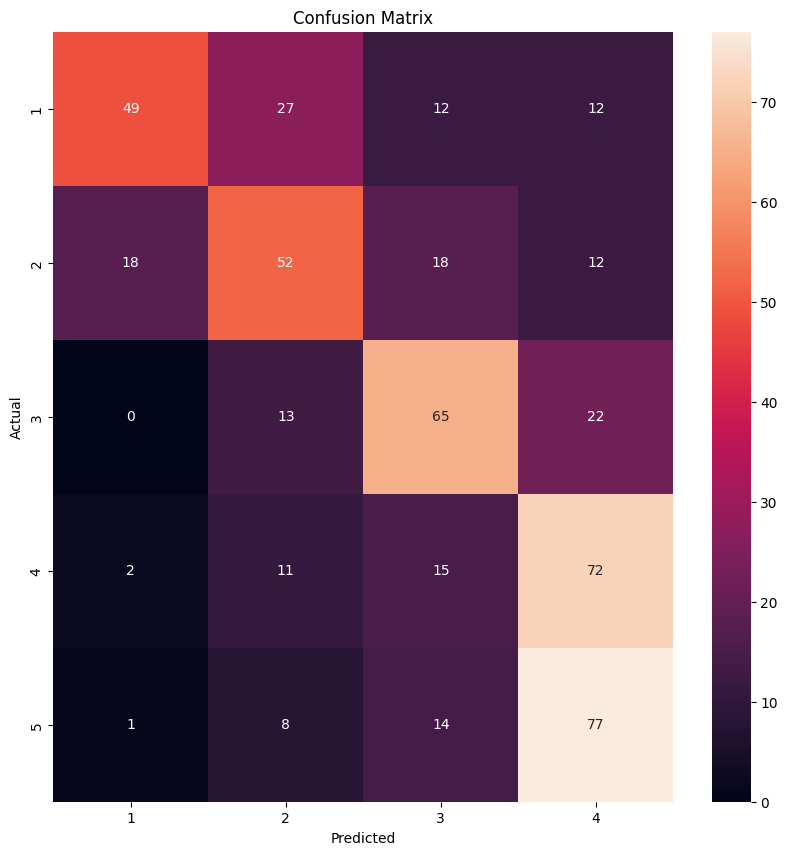

In [36]:
# Plot the confusion matrix using sns library
# Compute the confusion matrix using the true labels and the predictions
confusion_matrix = pandas.crosstab(pandas.Series(true_labels, name='Actual'), pandas.Series(predictions, name='Predicted'))

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d')

# Add labels to the x and y axis
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We see that our model is good at predicting `Moderate Conservative` but completely fails at predicting `Conservative`. Not a single article was predicted as `Conservative` by the model. We aim to vizualize an example of an article.

In [39]:
# We make a funciton to randomly take a sample of the dataset and print the predicted and the true label
def print_sample(sample_id):
    # Get the sample from the dataframe
    sample = predicted_dataframe.iloc[sample_id]
    
    # Print the text, the predicted label and the true label
    print(f"Text: {sample['text']}")
    print(f"Predicted label: {sample['predicted_label']}")
    print(f"True label: {sample['true_label']}")

# Print a sample
print_sample(450)

Text: 시럽급여' 논란에 윤재옥 "이야기 않겠다…언론 지적 알고 있다" 국민의힘 윤재옥 원내대표가 차기 정부 국정과제를 정하는 대통령직인수위원회에서 서울-양평고속도로 종점 변경을 논의했다는 주장은 억지스럽다고 비판했다. 윤석열 대통령의 부인인 김건희 전 코바나컨텐츠 대표 일가 소유 땅 인근으로의 종점 변경이 윤석열 대통령 인수위원회 시기에 이뤄졌다는 야당의 공세에 대한 반박이다.

윤 원내대표는 14일 국회에서 열린 '원내대표 취임 100일 기자간담회'에서 '서울-양평고속도로 논란을 국정조사로 해소하는 것이 맞지 않나'라는 질문에 "인수위가 관여했다는데 인수위는 정부 정책 방향을 잡는 곳이지 개별 고속도로 노선을 인수위에서 논의해 출범하자마자 관여한다는 것은 상식적이지 않다"고 답했다.

윤 원내대표는 "인수위는 다음 국정 아젠다를 찾는 조직이고 그런 취지로 인수위를 운영하는데 여러 가지 상황상 지금 야당의 주장이 억지스럽다"며 "또 양평에 선산이 있고 선대 때부터 있던 땅이 있다는 이유로 (김 전 대표에게 특혜가 있었다고) 몰고가는 것은 바람직하지 않다"고 주장했다.

윤 원내대표는 "이 상황은 국정조사를 할 상황이 아니다"라며 "17일 (원희룡) 장관이 귀국하는대로 국토위원회 문을 열기로 했다. 거기에서 야당이 질문할 사항이 있으면 질의하고 답변하는 과정을 통해 문제가 정리되는 것이 맞다"고 기존 입장을 재확인했다.

'한국갤럽의 이번 주 여론조사에서 윤 대통령의 지지율이 지난 주에 비해 6%P 떨어진 요인을 뭐라고 분석하나'라는 질문에 윤 원내대표는 "오늘 발표됐다니 더 분석해보겠다"며 "여의도연구소라든지 핵심 실무자들과 논의해 지지율 관련 분석을 해보겠다"고 답을 피했다. (☞관련기사 : 尹지지율 6%P↓ '최대 낙폭', 日 오염수 방류 여파)

지난 12일 실업급여 당정 공청회에서 나온 "시럽급여", '여성·청년이 실업급여로 명품 사고 해외여행 간다' 등 발언에 대한 생각을 묻는 질문에 윤 원내대표는 "개별적 표현에 대해서는 이야기하지 않겠다"며 

In [40]:
# Save the final dataframe containig the predictions and true labels
predicted_dataframe.to_csv("political_orientation_dataset/predictions.csv", index=False)